# Convolutional Neural Network

image data

In [1]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

2024-05-29 18:04:41.589905: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-29 18:04:41.593204: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-29 18:04:41.637742: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 18:04:42.476096: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Tensorflow

In [3]:
import tensorflow as tf

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.16.1
Num GPUs Available:  0


## Dataset

In [4]:
annotations_path = 'dataset/density_info.csv'
img_path = 'dataset/img'
pp_path = 'dataset/pp'
roi_path = 'dataset/roi'

In [5]:
df = pd.read_csv(annotations_path)

In [6]:
df

,id,file_path,image_path,SeriesDescription,patient_id,image view,breast density
0,0,1.3.6.1.4.1.9590.100.1.2.239949064412092068706...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.239949...,full mammogram images,P_00017,MLO,2
1,1,1.3.6.1.4.1.9590.100.1.2.397840223011442643919...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.397840...,full mammogram images,P_00238,CC,3
2,2,1.3.6.1.4.1.9590.100.1.2.204033481911004862841...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.204033...,full mammogram images,P_00699,CC,3
3,3,1.3.6.1.4.1.9590.100.1.2.179488205110519665924...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.179488...,full mammogram images,P_01617,CC,2
4,4,1.3.6.1.4.1.9590.100.1.2.151178406511629586605...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.151178...,full mammogram images,P_00464,MLO,3
...,...,...,...,...,...,...,...
3281,3281,1.3.6.1.4.1.9590.100.1.2.206174998211439771426...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.206174...,full mammogram images,P_00322,MLO,2
3282,3282,1.3.6.1.4.1.9590.100.1.2.211427675111583558805...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.211427...,full mammogram images,P_00019,MLO,4
3283,3283,1.3.6.1.4.1.9590.100.1.2.529156274123405251229...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.529156...,full mammogram images,P_01040,CC,3
3284,3284,1.3.6.1.4.1.9590.100.1.2.744141121110160190397...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.744141...,full mammogram images,P_01462,CC,2


In [7]:
df['breast density'] = df['breast density'].replace(3, 2)
df['breast density'] = df['breast density'] - 1
df['breast density'] = df['breast density'].replace(3, 2)

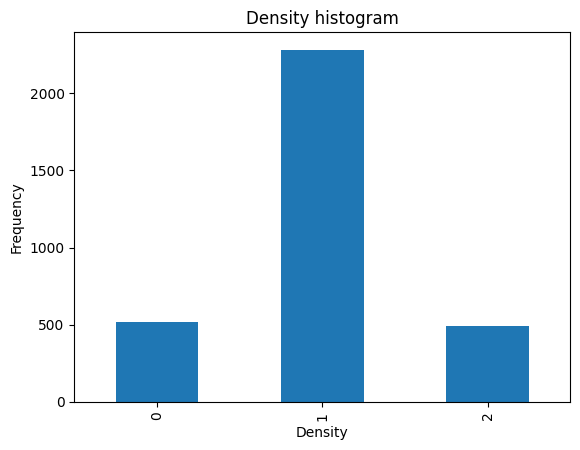

classes: [1 0 2]
class A (0) count: 516
class B + C (1) count: 2281
class D (2) count: 489


In [8]:
df['breast density'].value_counts().sort_index().plot(kind='bar')

plt.title('Density histogram')
plt.xlabel('Density')
plt.ylabel('Frequency')

plt.show()

print(f'classes: {df["breast density"].unique()}')
print(f'class A (0) count: {len(df[df["breast density"] == 0])}')
print(f'class B + C (1) count: {len(df[df["breast density"] == 1])}')
print(f'class D (2) count: {len(df[df["breast density"] == 2])}')

ID: 509, Class: 1


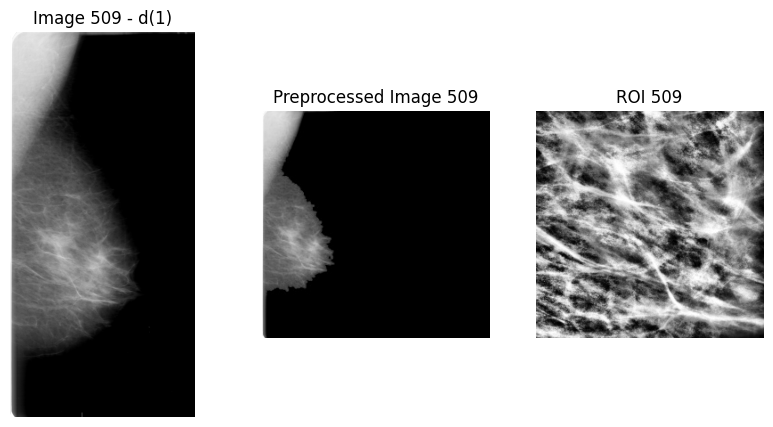

ID: 1725, Class: 1


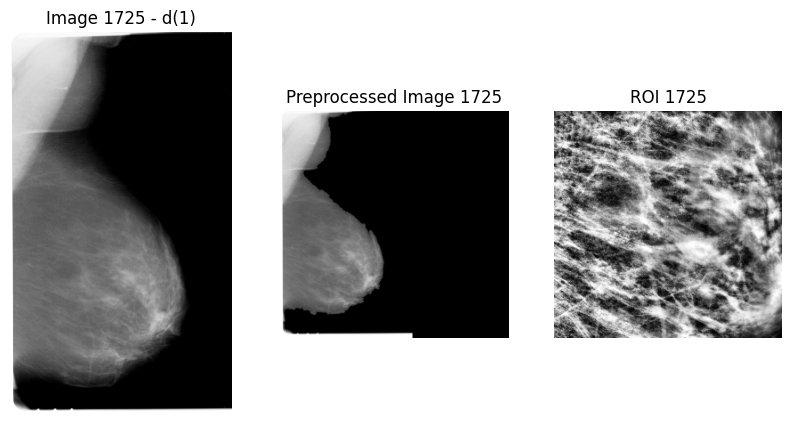

ID: 1878, Class: 1


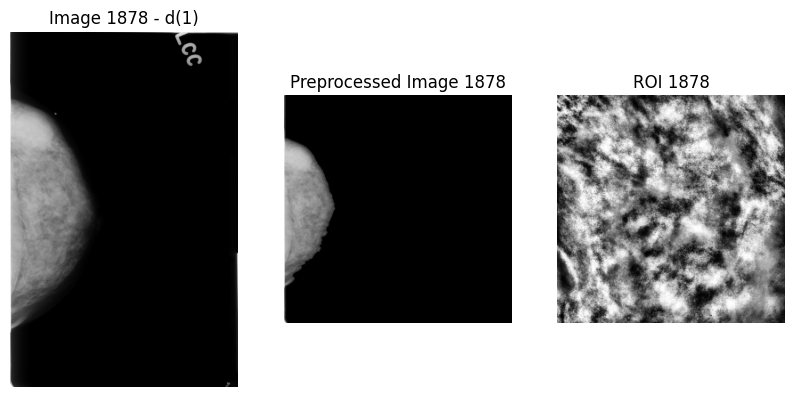

ID: 2910, Class: 1


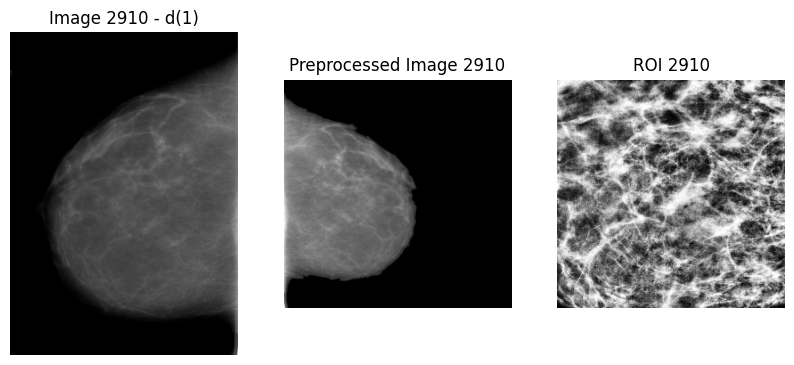

ID: 1057, Class: 1


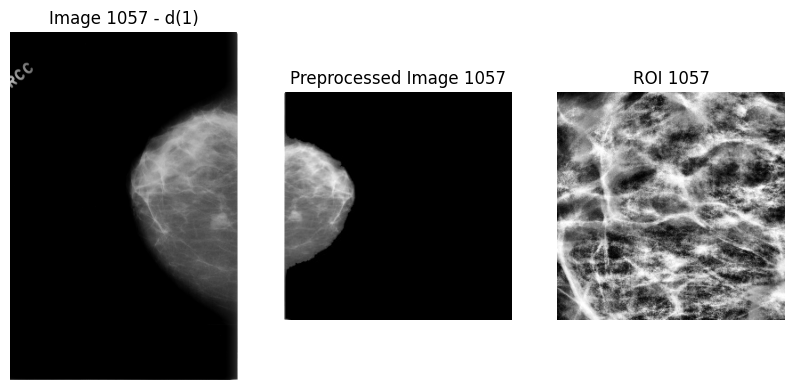

In [9]:
# match the image with the annotations

random_samples = df.sample(5)

for row in random_samples.iterrows():
    id = row[1]['id']
    density = row[1]['breast density']

    print(f"ID: {id}, Class: {density}")

    img = cv2.imread(f'{img_path}/{id}.jpg', cv2.IMREAD_GRAYSCALE)
    pp_img = cv2.imread(f'{pp_path}/{id}.jpg', cv2.IMREAD_GRAYSCALE)
    roi = cv2.imread(f'{roi_path}/{id}.jpg', cv2.IMREAD_GRAYSCALE)

    # plot the images

    fig, ax = plt.subplots(1, 3, figsize=(10, 5))

    ax[0].imshow(img, cmap='gray')
    ax[0].set_title(f'Image {id} - d({density})')
    ax[0].axis('off')

    ax[1].imshow(pp_img, cmap='gray')
    ax[1].set_title(f'Preprocessed Image {id}')
    ax[1].axis('off')

    ax[2].imshow(roi, cmap='gray')
    ax[2].set_title(f'ROI {id}')
    ax[2].axis('off')

    plt.show()

## Classification

### Preparation

In [10]:
y = df['breast density']

input_size = (256, 256, 1)
output_size = len(y.unique())

### Data generator (save on memory)

In [11]:
def process_img(img_path):

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    # img = img.reshape(-1, 256, 256, 1)
    img = img.astype('float32') / 255

    return img

def data_generator(df, batch_size, path):

    num_samples = len(df)

    while True:

        for offset in range(0, num_samples, batch_size):

            batch_samples = df.iloc[offset:offset+batch_size]
            images = []
            labels = []

            for _, row in batch_samples.iterrows():
                img_path = f"{path}/{row['id']}.jpg"
                img = process_img(img_path)
                images.append(img)
                labels.append(row['breast density'])

            X = np.array(images)
            y = np.array(labels)

            yield X, y

Sample batch shape: (2, 256, 256)
Sample labels shape: (2,)


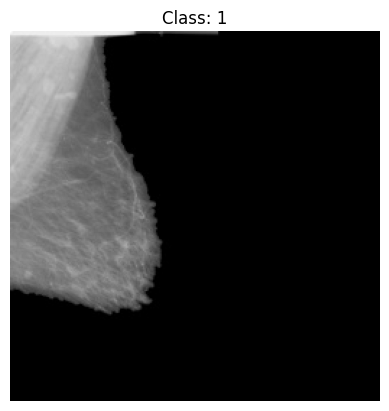

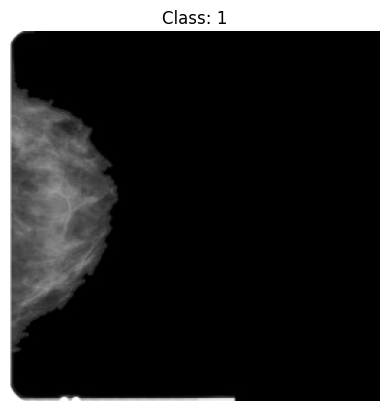

Sample batch shape: (2, 256, 256)
Sample labels shape: (2,)


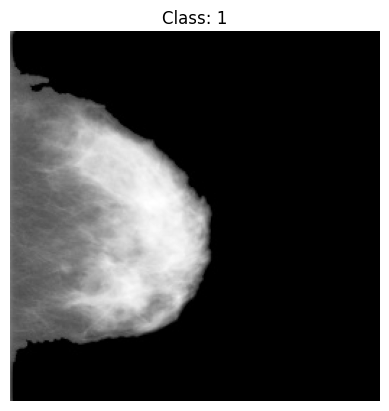

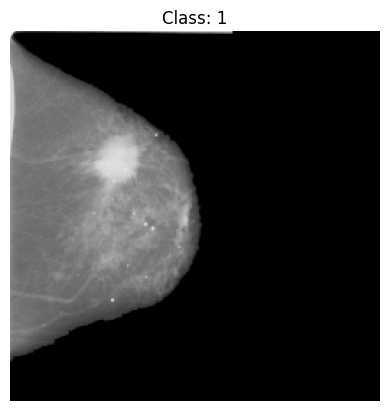

In [12]:
train_generator = data_generator(df, 2, pp_path)

X_sample, y_sample = next(train_generator)
print(f'Sample batch shape: {X_sample.shape}')
print(f'Sample labels shape: {y_sample.shape}')

for i in range(2):
    plt.imshow(X_sample[i].reshape(256, 256), cmap='gray')
    plt.title(f'Class: {y_sample[i]}')
    plt.axis('off')
    plt.show()

X_sample, y_sample = next(train_generator)
print(f'Sample batch shape: {X_sample.shape}')
print(f'Sample labels shape: {y_sample.shape}')

for i in range(2):
    plt.imshow(X_sample[i].reshape(256, 256), cmap='gray')
    plt.title(f'Class: {y_sample[i]}')
    plt.axis('off')
    plt.show()

### Architecture

In [13]:
def create_model():

    model = Sequential([

        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_size, name='input'),
        Dropout(rate=0.25),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        Dropout(rate=0.25),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        Dropout(rate=0.25),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),

        Dense(128, activation='relu'),
        Dense(output_size, activation='softmax', name='density')

    ])

    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

                  
    return model

### Using original (pre-processed) images

In [14]:
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
batch_size = 32

train_generator = data_generator(x_train, batch_size, pp_path)
test_generator = data_generator(x_test, batch_size, pp_path)

In [15]:
model = create_model()
model.summary()

/home/mikel/code/BreastDensity/env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (Conv2D)                  │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 254, 254, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 125, 125, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ density (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,838,787 (56.61 MB)

 Trainable params: 14,838,787 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
start = time.time()
history = model.fit(train_generator,
                    steps_per_epoch=len(x_train) // batch_size,
                    epochs=10,
                    validation_data=test_generator,
                    validation_steps=len(x_test) // batch_size
                    #callbacks=[EarlyStopping(patience=3)]
                    )
end = time.time() - start

Epoch 1/10
59/82 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6372 - loss: 0.9534

KeyboardInterrupt: 

In [ ]:
print('Training time:', end)

Training time: 1093.7831451892853


In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

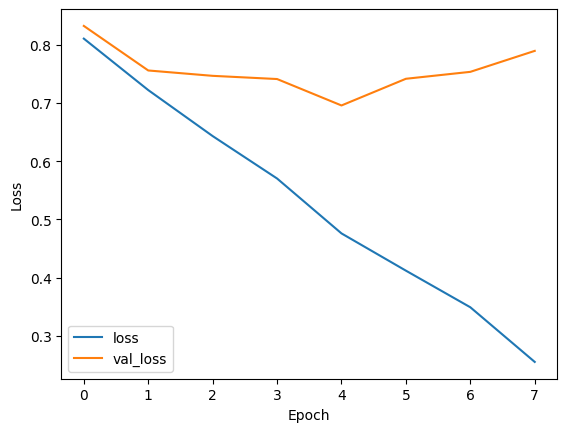

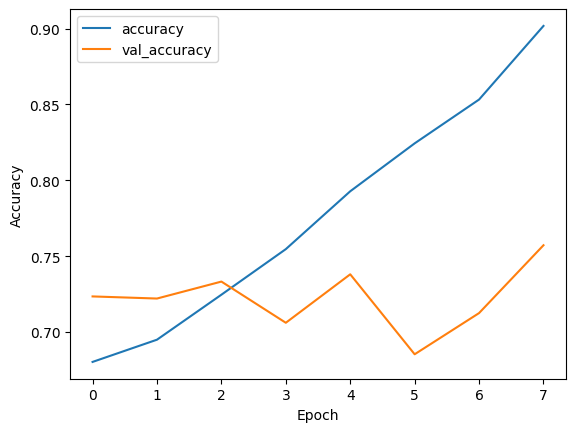

In [ ]:
# Plot the loss

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
x_testv, y_testv = next(test_generator)

loss, accuracy = model.evaluate(x_testv, y_testv)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.7188 - loss: 0.7696


In [ ]:
# Save the model
timestamp = pd.Timestamp.now().strftime('%Y-%m-%d_%H-%M-%S')
model.save(f'models/cnn_pp_{timestamp}.h5')

### Using ROI

In [ ]:
batch_size = 32

train_generator = data_generator(x_train, batch_size, roi_path)
test_generator = data_generator(x_test, batch_size, roi_path)

In [ ]:
model = create_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (Conv2D)                  │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 254, 254, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 125, 125, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ density (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,838,787 (56.61 MB)

 Trainable params: 14,838,787 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
start = time.time()
history = model.fit(train_generator,
                    steps_per_epoch=len(x_train) // batch_size,
                    epochs=10,
                    validation_data=test_generator,
                    validation_steps=len(x_test) // batch_size
                    validation_steps=len(x_test) // batch_size
                    #callbacks=[EarlyStopping(patience=3)]
                    )
end = time.time() - start

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.6204 - loss: 1.4638 - val_accuracy: 0.7109 - val_loss: 0.8424
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.6889 - loss: 0.8434 - val_accuracy: 0.7061 - val_loss: 0.7871
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.6921 - loss: 0.7256 - val_accuracy: 0.6661 - val_loss: 0.7806
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.7561 - loss: 0.5618 - val_accuracy: 0.7476 - val_loss: 0.6509
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.8196 - loss: 0.4434 - val_accuracy: 0.7476 - val_loss: 0.6075
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.8447 - loss: 0.3550 - val_accuracy: 0.6933 - val_loss: 0.6933
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.8633 - loss: 0.3143 - val_accuracy: 0.6438 - val_loss: 0.7927
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.8994 - loss: 0.2716 - val_accuracy: 0.6518 - v

In [ ]:
print('Training time:', end)

Training time: 1095.4929604530334


In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

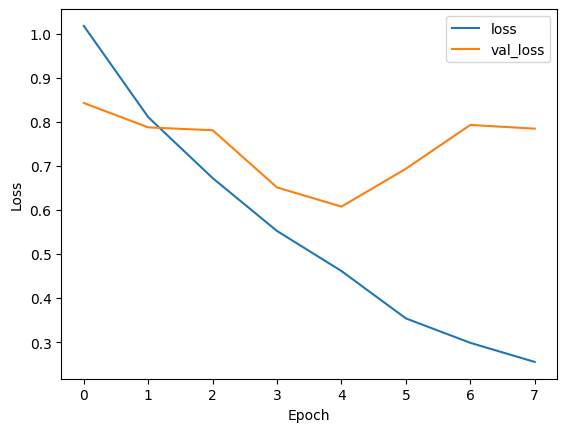

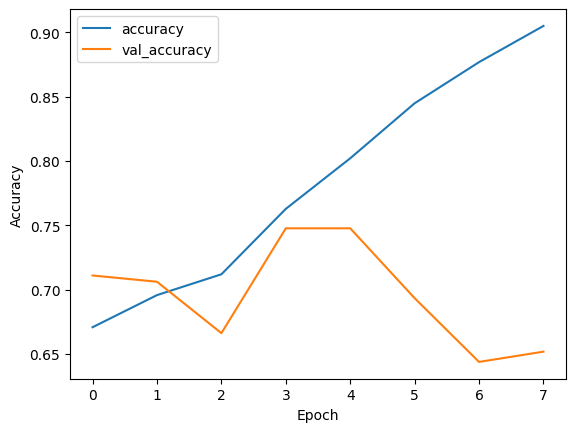

In [ ]:
# Plot the loss

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
x_testv, y_testv = next(test_generator)

loss, accuracy = model.evaluate(x_testv, y_testv)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.6875 - loss: 0.8845


In [ ]:
# Save the model
timestamp = pd.Timestamp.now().strftime('%Y-%m-%d_%H-%M-%S')
model.save(f'models/cnn_roi_{timestamp}.h5')